In [35]:
# Imported Libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.tree import export_graphviz
import pydot

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import imblearn.pipeline

from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_tree

from hyperopt import hp
from hyperopt import fmin, tpe

%matplotlib inline
plt.style.use('ggplot')


# Removing warnings
import warnings
warnings.filterwarnings("ignore")



In [2]:
!pip install shap

     |████████████████████████████████| 356 kB 4.0 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491644 sha256=4b8ffb7007a9d8ff7ad6977a1fb4e7d75c10430763846a4c3fab1647045a5097
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [36]:
df=pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/New_task/creditcard.csv')
df.head()

Time        V1        V2        V3  ...       V27       V28  Amount  Class
0   0.0 -1.359807 -0.072781  2.536347  ...  0.133558 -0.021053  149.62      0
1   0.0  1.191857  0.266151  0.166480  ... -0.008983  0.014724    2.69      0
2   1.0 -1.358354 -1.340163  1.773209  ... -0.055353 -0.059752  378.66      0
3   1.0 -0.966272 -0.185226  1.792993  ...  0.062723  0.061458  123.50      0
4   2.0 -1.158233  0.877737  1.548718  ...  0.219422  0.215153   69.99      0

[5 rows x 31 columns]

In [37]:
df.shape

(284807, 31)

In [38]:
#Checking Null values and type of values
df.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [39]:
df.isnull().sum().sum()

0

In [40]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [41]:
df.describe ()

Time            V1  ...         Amount          Class
count  284807.000000  2.848070e+05  ...  284807.000000  284807.000000
mean    94813.859575  3.919560e-15  ...      88.349619       0.001727
std     47488.145955  1.958696e+00  ...     250.120109       0.041527
min         0.000000 -5.640751e+01  ...       0.000000       0.000000
25%     54201.500000 -9.203734e-01  ...       5.600000       0.000000
50%     84692.000000  1.810880e-02  ...      22.000000       0.000000
75%    139320.500000  1.315642e+00  ...      77.165000       0.000000
max    172792.000000  2.454930e+00  ...   25691.160000       1.000000

[8 rows x 31 columns]

In [42]:
# Define all features
featr = [col for col in df.columns if 'Class' not in col]

len(featr)

30

# Data Explorations

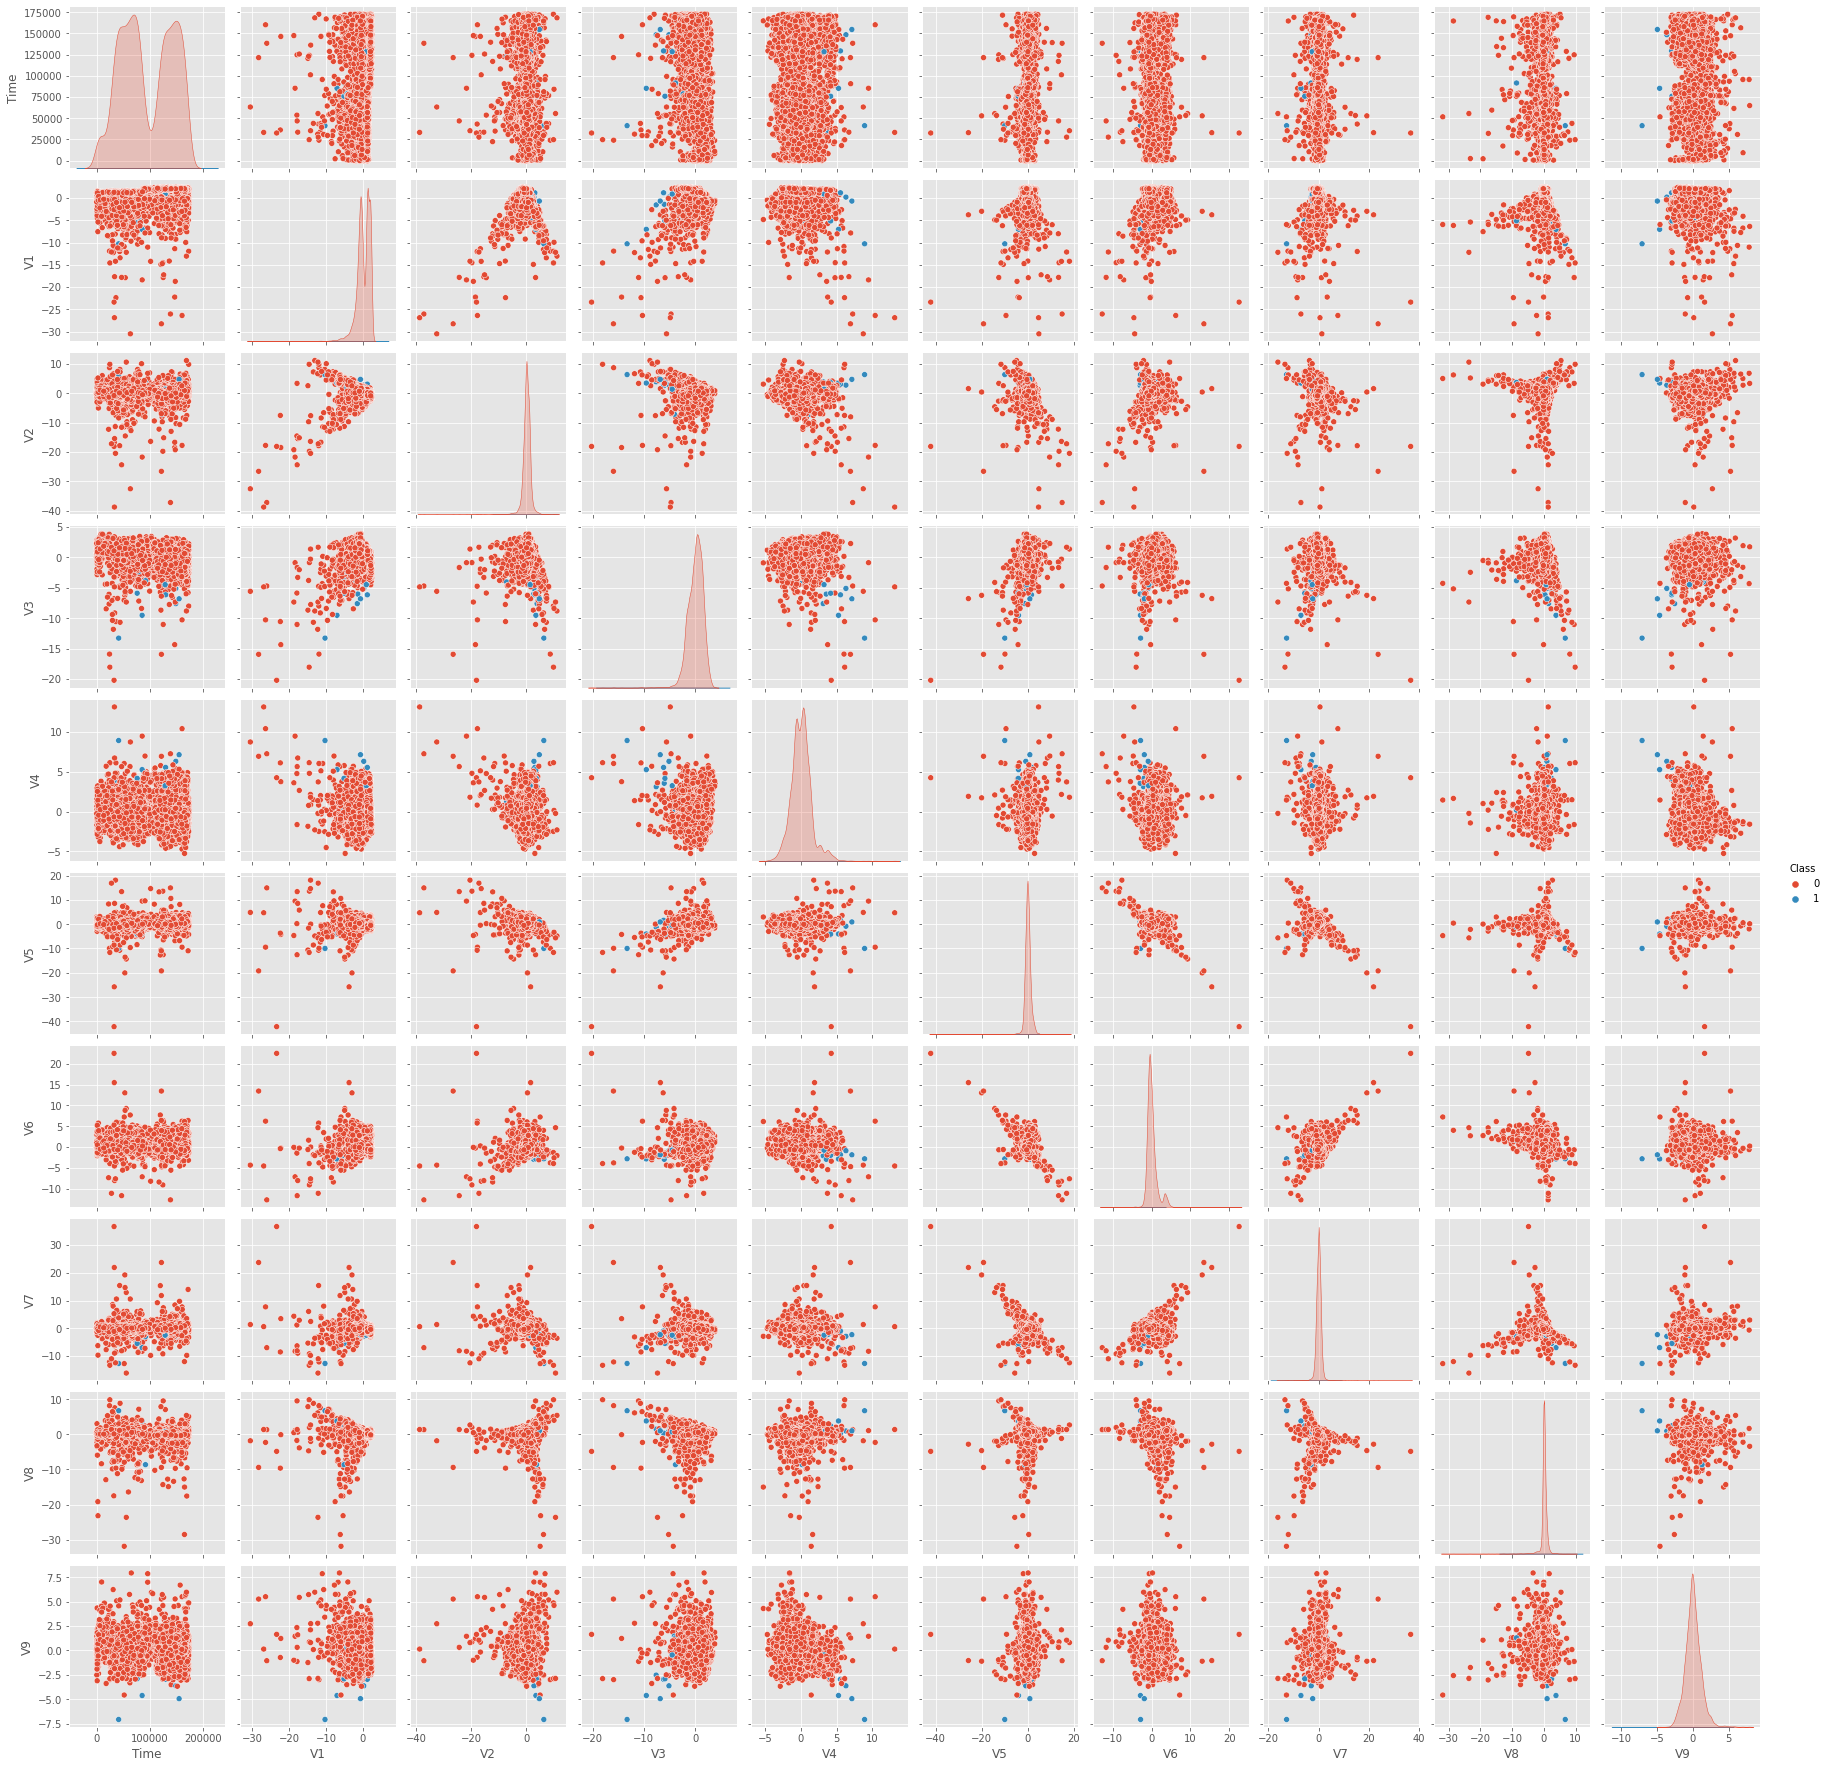

In [ ]:
sns.pairplot(df[featr[:10]+['Class']].sample(10000, random_state=1), hue='Class')

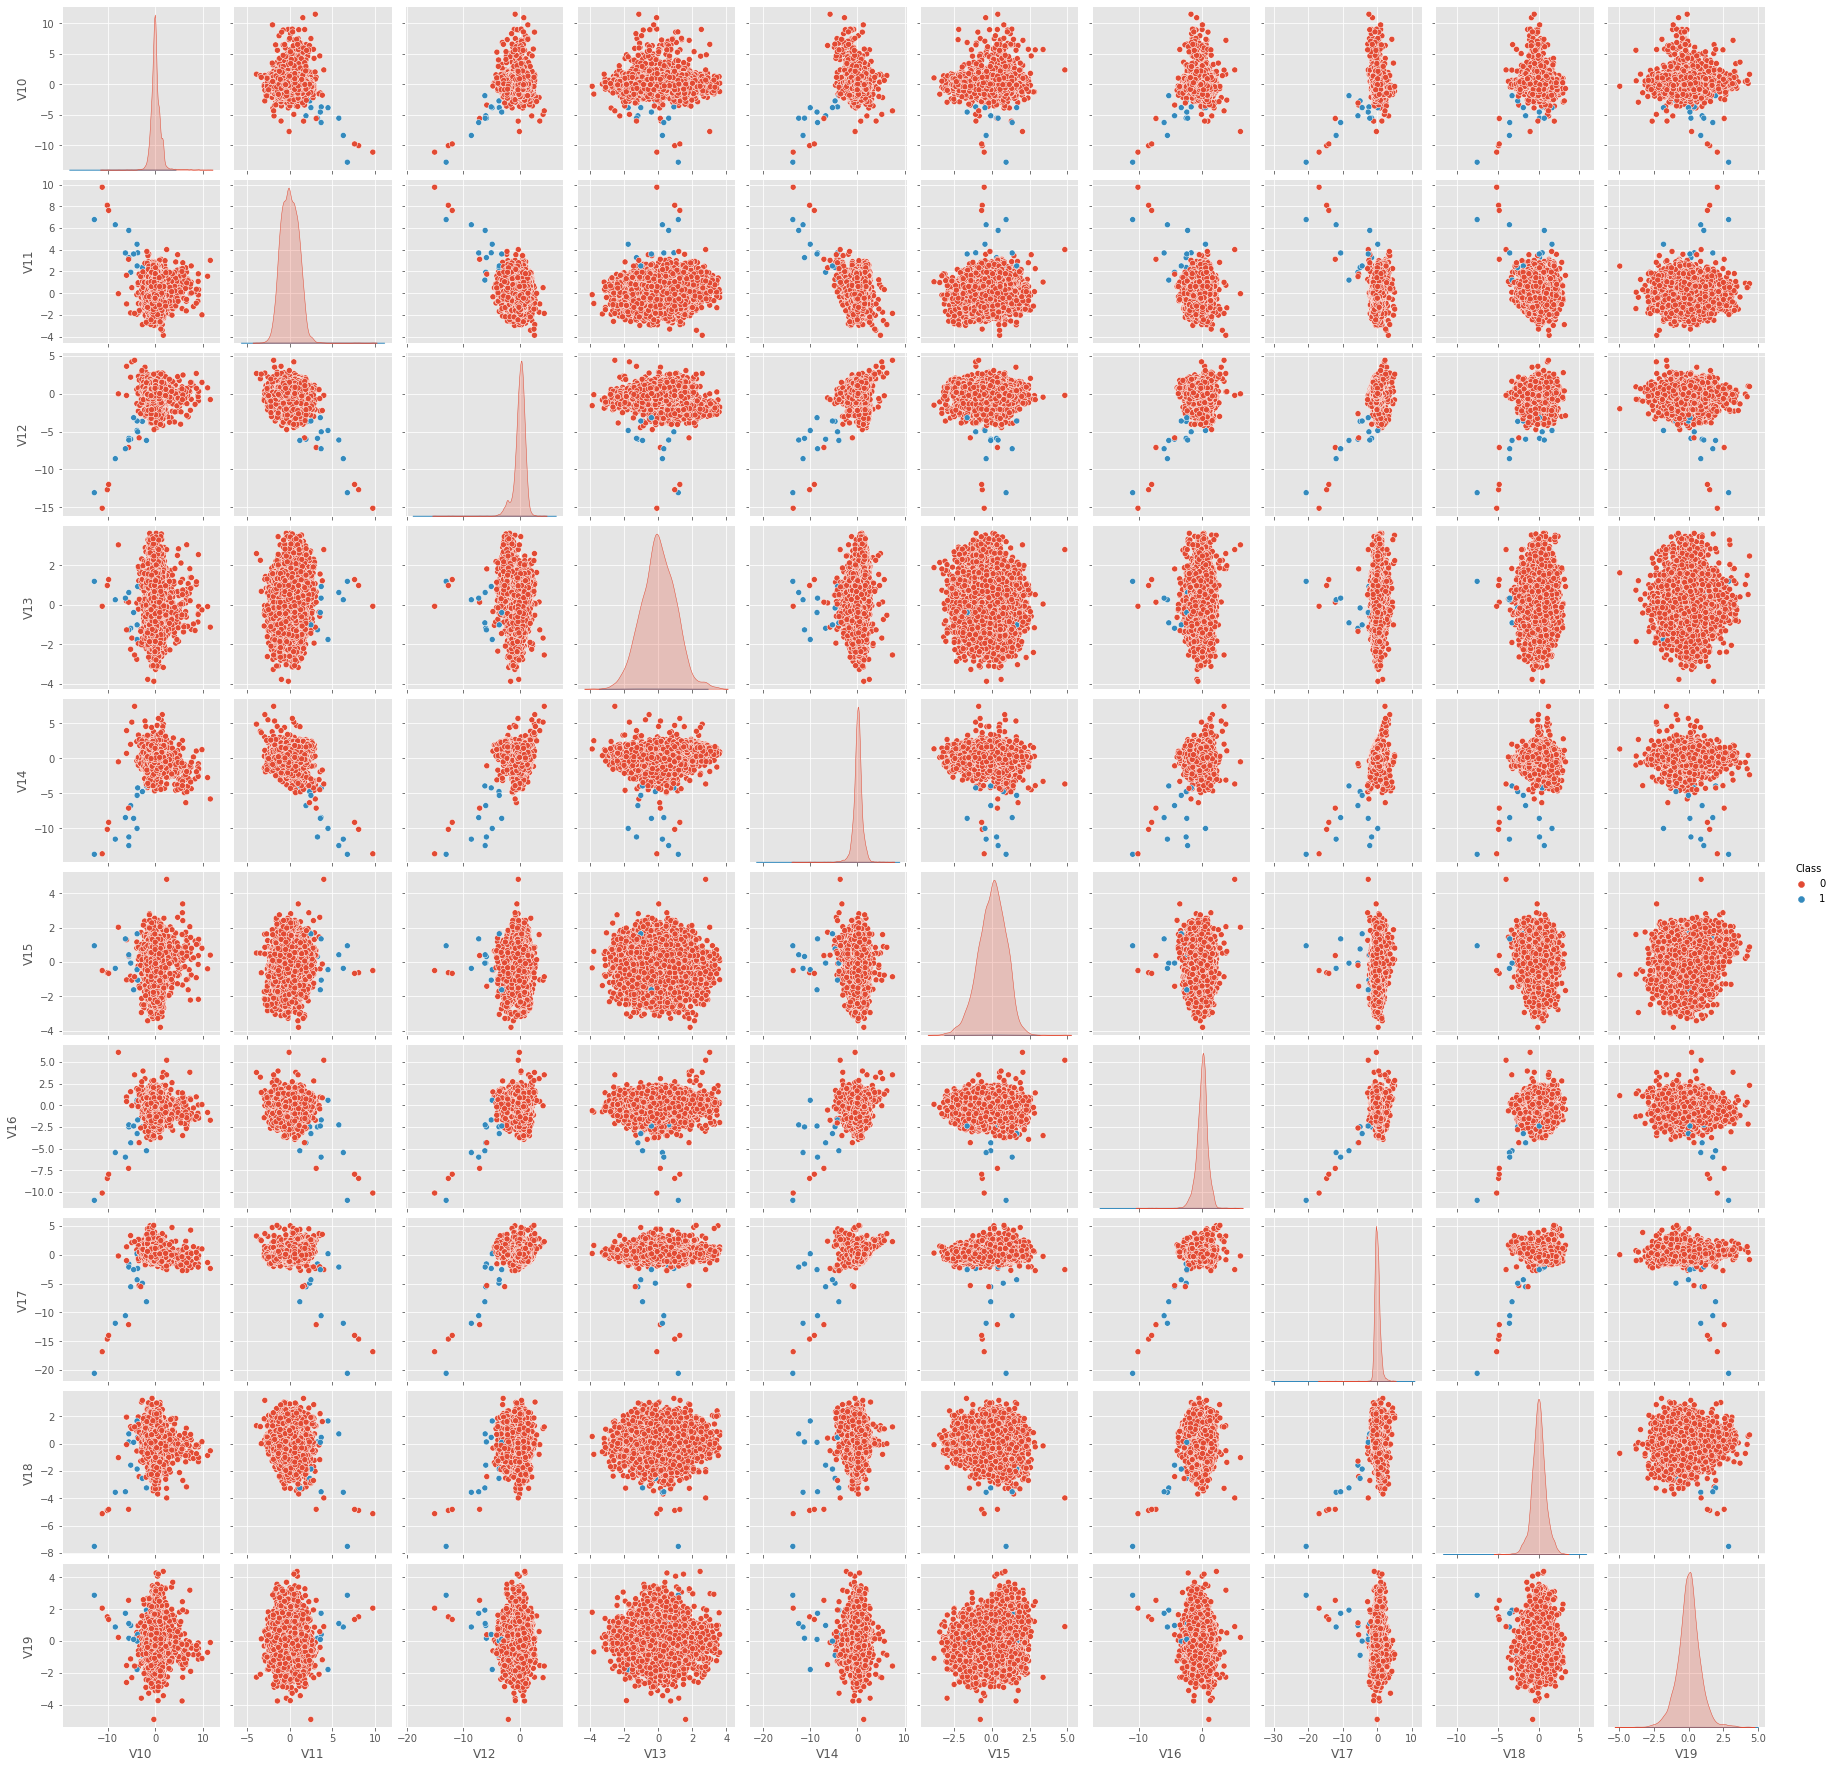

In [ ]:
sns.pairplot(df[featr[10:20]+['Class']].sample(10000, random_state=1), hue='Class')

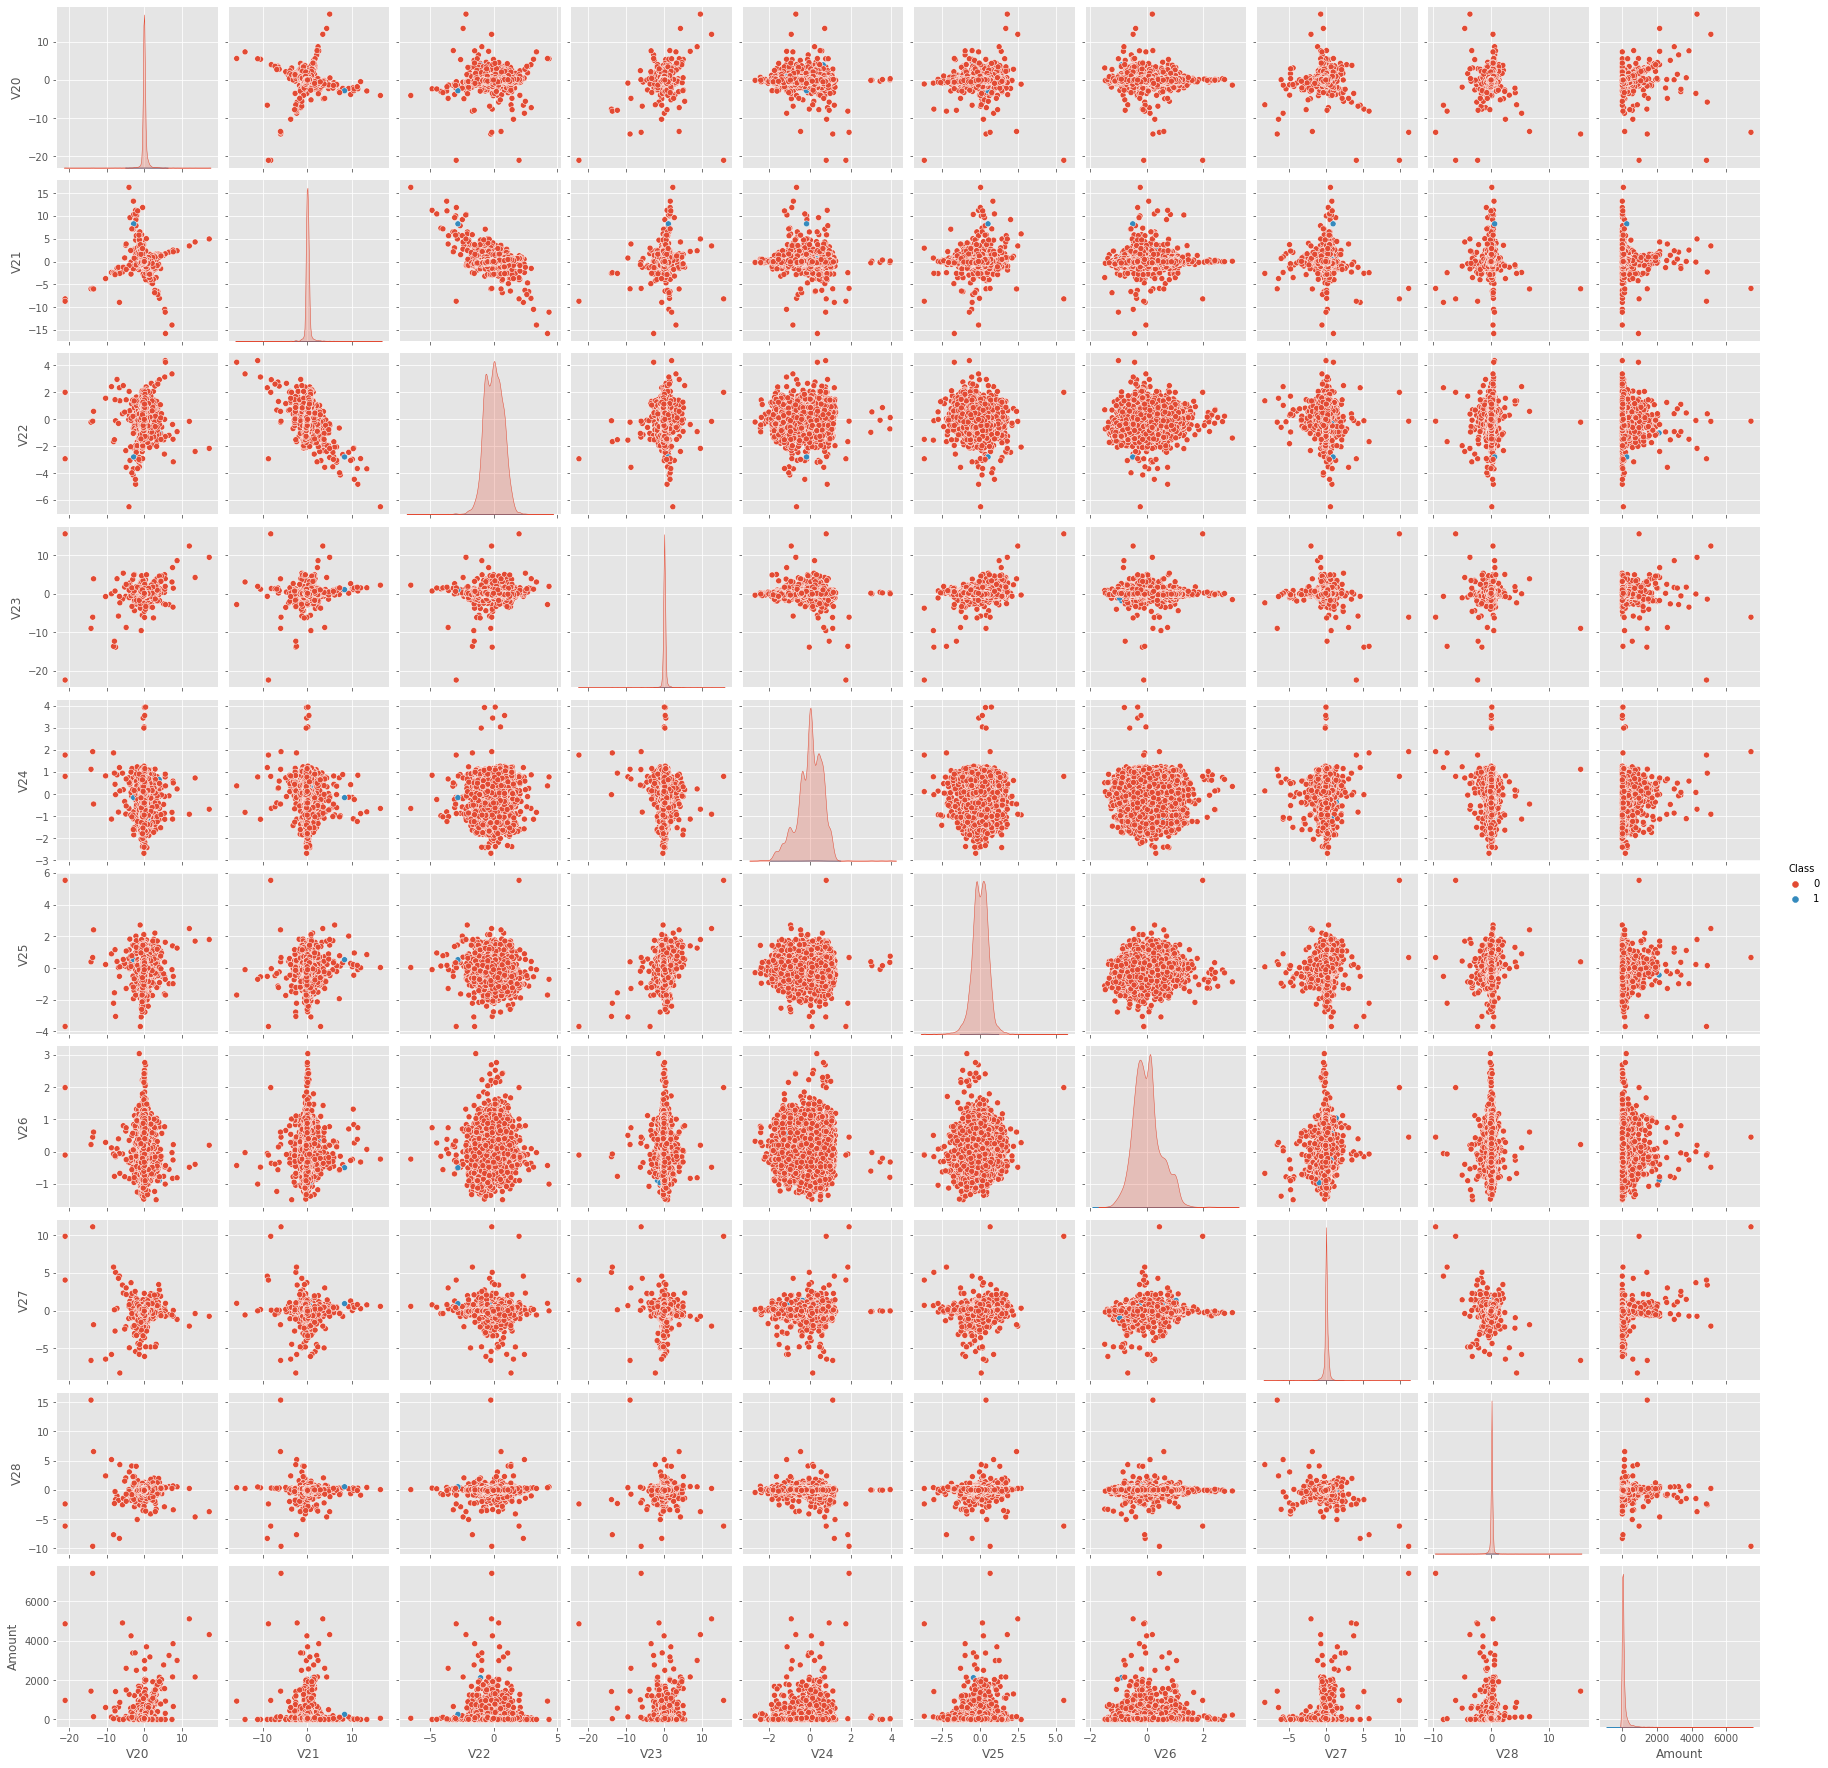

In [ ]:
sns.pairplot(df[featr[20:]+['Class']].sample(10000, random_state=1), hue='Class')

In [44]:
target = 'Class'

In [43]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

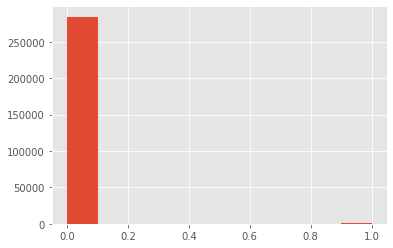

In [ ]:
df.Class.hist()

In [50]:
new_df1 = df

In [51]:
new_df1['Hour'] = new_df1 ['Time'].apply(lambda x: np.floor(x / 3600))

tmp = new_df1.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
new_df1 = pd.DataFrame(tmp)
new_df1.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
new_df1.head()



Hour  Class   Min      Max  ...        Sum        Mean   Median            Var
0   0.0      0   0.0  7712.43  ...  256572.87   64.774772   12.990   45615.821201
1   0.0      1   0.0   529.00  ...     529.00  264.500000  264.500  139920.500000
2   1.0      0   0.0  1769.69  ...  145806.76   65.826980   22.820   20053.615770
3   1.0      1  59.0   239.93  ...     298.93  149.465000  149.465   16367.832450
4   2.0      0   0.0  4002.88  ...  106989.39   68.803466   17.900   45355.430437

[5 rows x 9 columns]

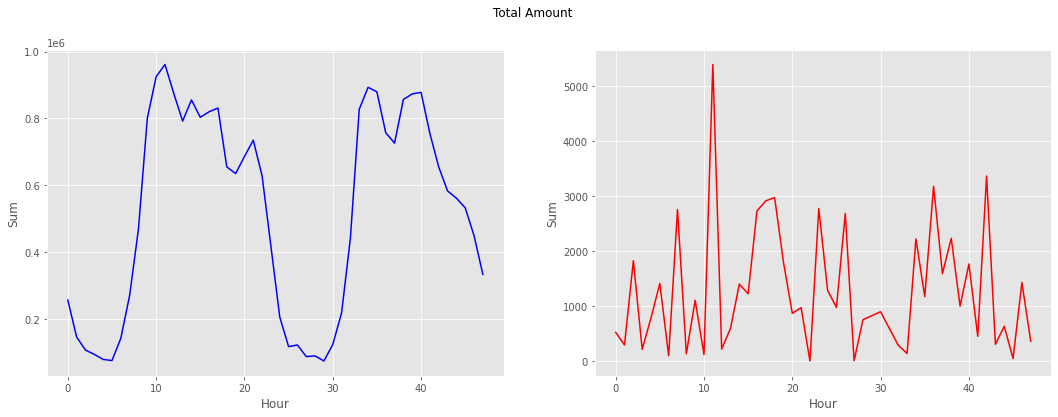

In [53]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=new_df1.loc[new_df1.Class==0],color="blue" )
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=new_df1.loc[new_df1.Class==1], color="red")
plt.suptitle("Total Amount")
plt.show();

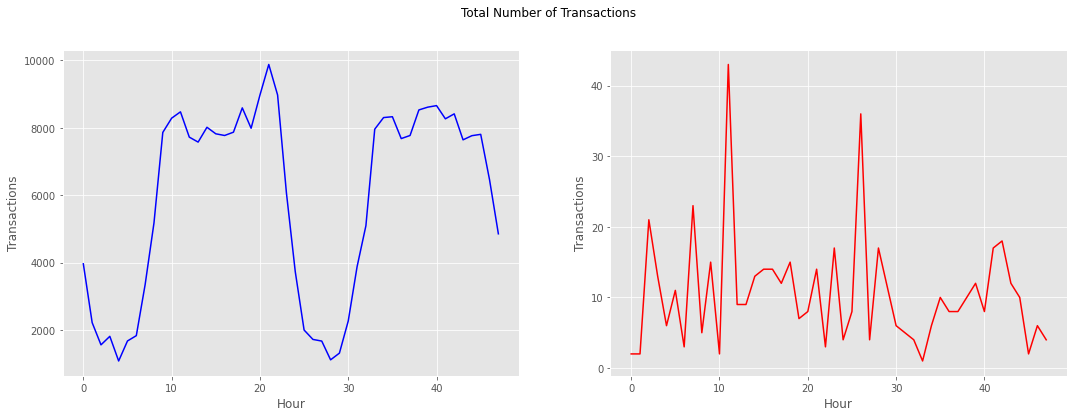

In [54]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=new_df1.loc[new_df1.Class==0], color="blue"  )
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=new_df1.loc[new_df1.Class==1], color="red")
plt.suptitle("Total Number of Transactions")
plt.show();

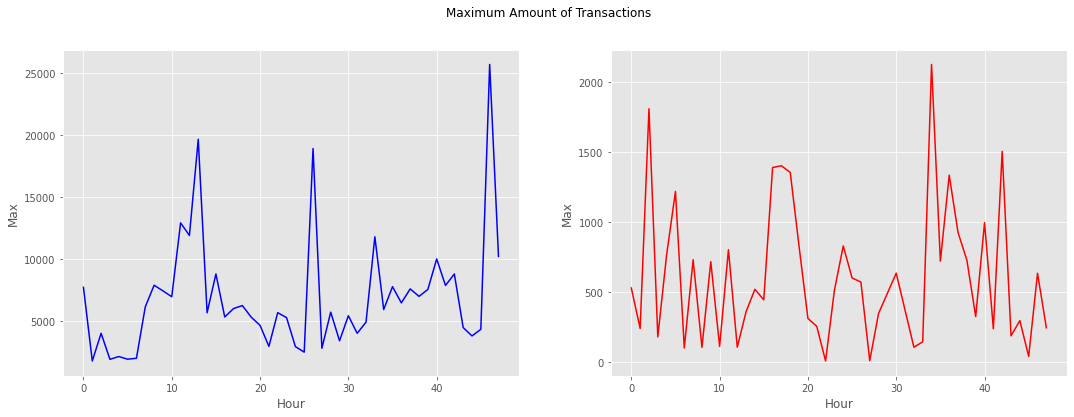

In [55]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=new_df1.loc[new_df1.Class==0], color="blue" )
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=new_df1.loc[new_df1.Class==1], color="red")
plt.suptitle("Maximum Amount of Transactions")
plt.show();

In [ ]:
# Fraud and non-fraud transaction shape
fraud = df[df['Class']==1]
normal = df[df['Class']==0]

print(f"Shape of Fraudulant transactions: {fraud.shape}")
print(f"Shape of Non-Fraudulant transactions: {normal.shape}")



Shape of Fraudulant transactions: (492, 31)
Shape of Non-Fraudulant transactions: (284315, 31)


In [ ]:
pd.concat([fraud.Amount.describe(), normal.Amount.describe()], axis=1)

Amount         Amount
count   492.000000  284315.000000
mean    122.211321      88.291022
std     256.683288     250.105092
min       0.000000       0.000000
25%       1.000000       5.650000
50%       9.250000      22.000000
75%     105.890000      77.050000
max    2125.870000   25691.160000

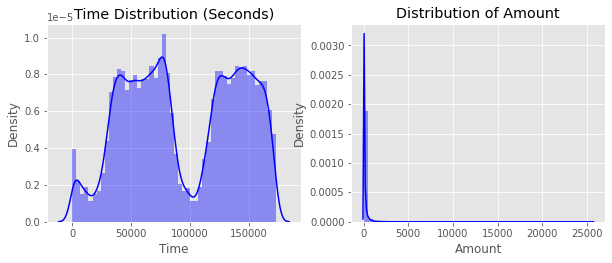

In [ ]:
# plot the time feature
plt.figure(figsize=(10,8))

plt.subplot(2, 2, 1)
plt.title('Time Distribution (Seconds)')

sns.distplot(df['Time'], color='blue');

#plot the amount feature
plt.subplot(2, 2, 2)
plt.title('Distribution of Amount')
sns.distplot(df['Amount'],color='blue');

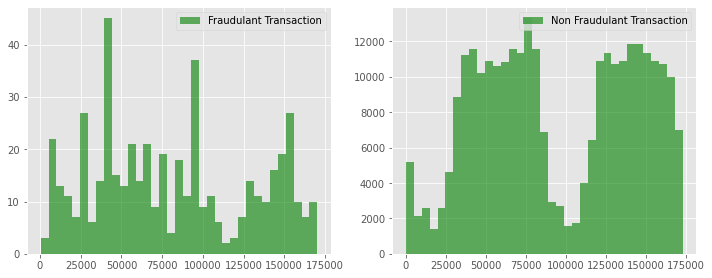

In [ ]:
# data[data.Class == 0].Time.hist(bins=35, color='blue', alpha=0.6)
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
df[df.Class == 1].Time.hist(bins=35, color='green', alpha=0.6, label="Fraudulant Transaction")
plt.legend()

plt.subplot(2, 2, 2)
df[df.Class == 0].Time.hist(bins=35, color='green', alpha=0.6, label="Non Fraudulant Transaction")
plt.legend()



# Correlation Matrix

In [ ]:
df_corr= df.corr()

In [ ]:
df_corr.style.background_gradient().set_precision(2)

In [ ]:
# Checking Significant Correlation with Class i.e; tagrget variable
df.corr()['Class'].sort_values()

V17      -0.326481
V14      -0.302544
V12      -0.260593
V10      -0.216883
V16      -0.196539
V3       -0.192961
V7       -0.187257
V18      -0.111485
V1       -0.101347
V9       -0.097733
V5       -0.094974
V6       -0.043643
Time     -0.012323
V24      -0.007221
V13      -0.004570
V15      -0.004223
V23      -0.002685
V22       0.000805
V25       0.003308
V26       0.004455
Amount    0.005632
V28       0.009536
V27       0.017580
V8        0.019875
V20       0.020090
V19       0.034783
V21       0.040413
V2        0.091289
V4        0.133447
V11       0.154876
Class     1.000000
Name: Class, dtype: float64

# Pre-processing of Data

In [ ]:
# Spliting the dat into train and test part
X = df[featr]
y = df[target]


In [ ]:
# Use stratify to ensure samples of fraud label are in the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, random_state=1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(213605, 30) (71202, 30) (213605,) (71202,)


In [ ]:
y_train.value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

# Predictive Model

In [ ]:
naive_preds = np.zeros(y_test.shape[0])
len(naive_preds)

71202

In [ ]:
roc_auc_score(y_test, naive_preds)

0.5

In [ ]:
print(classification_report(y_test, naive_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.00      0.00      0.00       123

    accuracy                           1.00     71202
   macro avg       0.50      0.50      0.50     71202
weighted avg       1.00      1.00      1.00     71202



 # Model

In [ ]:
num_boost_rounds = 1000
early_stopping_rounds = 10

initial_params = {'objective': 'binary:logistic', 'eval_metric': 'auc'}

In [ ]:


logreg_cv = cross_val_score(estimator=LogisticRegression(), 
                            X=X_train, 
                            y=y_train, 
                            scoring='roc_auc',
                            cv=StratifiedKFold(n_splits=5, random_state=1))



In [ ]:
rf_cv = cross_val_score(estimator=RandomForestClassifier(),
                         X=X_train, 
                         y=y_train,
                         scoring='roc_auc',
                         cv=StratifiedKFold(n_splits=5, random_state=1))

In [ ]:


xgb_cv = cross_val_score(estimator=XGBClassifier(num_boost_rounds=num_boost_rounds, 
                                                 early_stopping_rounds=early_stopping_rounds,
                                                 **initial_params),
                          X=X_train,
                          y=y_train,
                          scoring='roc_auc',
                          cv=StratifiedKFold(n_splits=5, random_state=1))



In [ ]:
print(f'Logistic Regression mean AUC score: {logreg_cv.mean()}')
print(f'Random Forest mean AUC score: {rf_cv.mean()}')
print(f'XGBoost mean  AUC score: {xgb_cv.mean()}')

Logistic Regression mean AUC score: 0.9141105925539865
Random Forest mean AUC score: 0.9425490585779374
XGBoost mean  AUC score: 0.9772782369919313


In [ ]:
model_cv_results = {'logreg': logreg_cv, 'random_forest': rf_cv, 'xgb': xgb_cv}

Text(0.5, 1.0, 'AUC scores using Different Classification Algorithms')

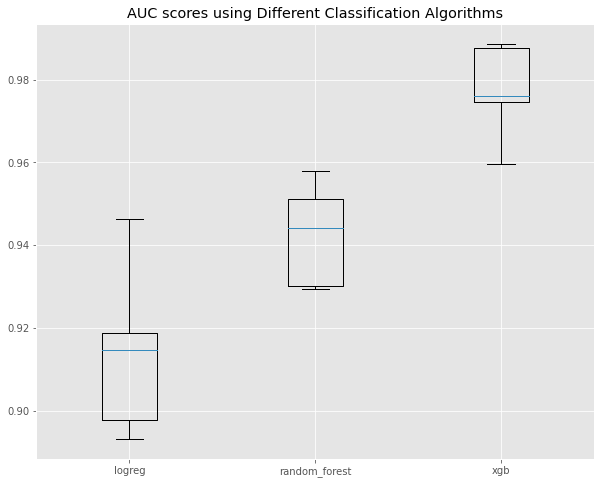

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
plt.boxplot(model_cv_results.values())
ax.set_xticklabels(model_cv_results.keys())
plt.title('AUC scores using Different Classification Algorithms')

# Sampling technique

Oversampling (Random)

In [ ]:
oversamp_pipeline = imblearn.pipeline.Pipeline([('oversample', RandomOverSampler(random_state=42)),
                                                ('xgb', XGBClassifier(num_boost_rounds=num_boost_rounds, 
                                                                      early_stopping_rounds=early_stopping_rounds,
                                                                      **initial_params))])

Undersampling (Random)

In [ ]:


undersamp_pipeline = imblearn.pipeline.Pipeline([('undersample', RandomUnderSampler(random_state=42)),
                                                 ('xgb', XGBClassifier(num_boost_rounds=num_boost_rounds, 
                                                                       early_stopping_rounds=early_stopping_rounds,
                                                                       **initial_params))])



Oversampling (SMOTE)

In [ ]:
smote_pipeline = imblearn.pipeline.Pipeline([('smote', SMOTE(random_state=42)),
                                             ('xgb', XGBClassifier(num_boost_rounds=num_boost_rounds, 
                                                                   early_stopping_rounds=early_stopping_rounds,
                                                                   **initial_params))])

# Cross validation

In [ ]:
sampling_methods = {'random_oversampling': oversamp_pipeline,
                    'random_undersampling': undersamp_pipeline,
                    'smote': smote_pipeline}

In [ ]:
sampling_cv_results = {}

for method, pipeline in sampling_methods.items():
    cv_results = cross_val_score(pipeline, X_train.values, y_train.values, cv=StratifiedKFold(n_splits=5, random_state=1), scoring='roc_auc')
    sampling_cv_results[method] = cv_results
    print(method, cv_results.mean())

random_oversampling 0.9737147148645258
random_undersampling 0.9759599618408392
smote 0.9741273051366768


Text(0.5, 1.0, 'AUC scores of XGB Classifier using Different Sampling Methods')

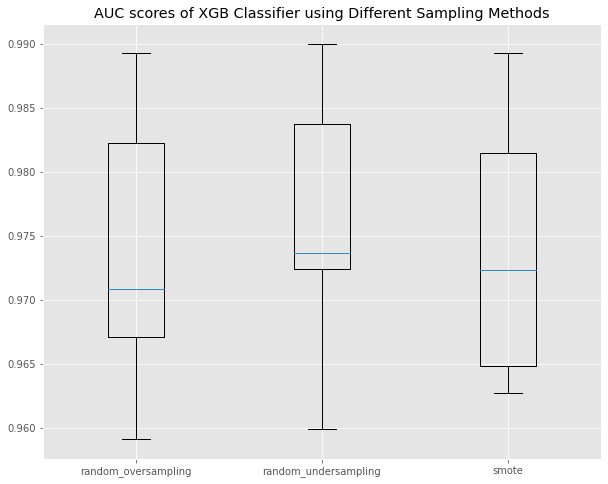

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
plt.boxplot(sampling_cv_results.values())
ax.set_xticklabels(sampling_cv_results.keys())
plt.title('AUC scores of XGB Classifier using Different Sampling Methods')

# Hyperparameter tuning using Hyperopt

In [ ]:
# Set up grid for hyperopt
space = {
    'max_depth': hp.quniform('max_depth', 4, 10, 2),
    'min_child_weight': hp.quniform('min_child_weight', 1, 20, 2),
    'gamma': hp.quniform('gamma', 0, 5, 0.5),
    'subsample': hp.uniform('subsample', 0.5, 0.9),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.9),
    'eta': hp.uniform('eta', 0.01, 0.3),
    'objective': 'binary:logistic',
    'eval_metric': 'auc'
}

In [ ]:
# Objective function
def objective(params):
    params = {'max_depth': int(params['max_depth']),
              'min_child_weight': int(params['min_child_weight']),
              'gamma': params['gamma'],
              'subsample': params['subsample'],
              'colsample_bytree': params['colsample_bytree'],
              'eta': params['eta'],
              'objective': params['objective'],
              'eval_metric': params['eval_metric']}
    
    xgb_clf = XGBClassifier(num_boost_rounds=num_boost_rounds, 
                            early_stopping_rounds=early_stopping_rounds,
                            **params)
    
    best_score = cross_val_score(xgb_clf, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=3).mean()
    
    loss = 1 - best_score 
    
    return loss

In [ ]:
best_result = fmin(fn=objective, space=space, max_evals=20, 
                   rstate=np.random.RandomState(42), algo=tpe.suggest)

100%|██████████| 20/20 [46:22<00:00, 139.14s/it, best loss: 0.02029098589252154]


In [ ]:
best_result

{'colsample_bytree': 0.5695966890029563,
 'eta': 0.24125725271732326,
 'gamma': 2.0,
 'max_depth': 10.0,
 'min_child_weight': 2.0,
 'subsample': 0.7108439230986429}

In [ ]:
best_params = best_result
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])
best_params['gamma'] = best_params['gamma']
best_params['colsample_bytree'] = round(best_params['colsample_bytree'], 1)
best_params['eta'] = round(best_params['eta'], 1)
best_params['subsample'] = round(best_params['subsample'], 1)
best_params

{'colsample_bytree': 0.6,
 'eta': 0.2,
 'gamma': 2.0,
 'max_depth': 10,
 'min_child_weight': 2,
 'subsample': 0.7}

# Best Model

Traning hyperparameter with hyperparameter

In [ ]:
final_model = imblearn.pipeline.Pipeline([('smote', SMOTE(random_state=1)),
                                          ('xgb', XGBClassifier(num_boost_rounds=num_boost_rounds,
                                                                early_stopping_rounds=early_stopping_rounds, 
                                                                **best_params))])

In [ ]:

final_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('smote',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=1, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, early_stopping_rounds=10,
                               eta=0.2, gamma=2.0, learning_rate=0.1,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=2, missing=None,
                               n_estimators=100, n_jobs=1, nthread=None,
                               num_boost_rounds=1000,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0

In [ ]:
final_preds = final_model.predict_proba(X_test.values)[:,1]

# Saving the final model predictions

In [ ]:
test = pd.merge(X_test, y_test, left_index=True, right_index=True)
test.head()

Time        V1        V2  ...       V28  Amount  Class
170722  120325.0 -1.508324 -1.885971  ... -0.046227   15.00      0
223193  143282.0  2.058549  0.109992  ... -0.034564    1.90      0
220019  141984.0  2.106311  0.008430  ... -0.086313   12.25      0
219991  141967.0  1.930257 -0.340094  ... -0.023725   37.25      0
178835  123804.0  1.937486 -2.092468  ... -0.031877  110.11      0

[5 rows x 31 columns]

In [ ]:
test.shape

(71202, 31)

In [ ]:
df_preds = test.copy()
df_preds['fraud_score'] = final_preds

In [ ]:
df_preds.head()

Time        V1        V2  ...  Amount  Class  fraud_score
170722  120325.0 -1.508324 -1.885971  ...   15.00      0     0.000216
223193  143282.0  2.058549  0.109992  ...    1.90      0     0.000311
220019  141984.0  2.106311  0.008430  ...   12.25      0     0.000102
219991  141967.0  1.930257 -0.340094  ...   37.25      0     0.000165
178835  123804.0  1.937486 -2.092468  ...  110.11      0     0.000089

[5 rows x 32 columns]

In [ ]:
df_preds['fraud_score'].describe()

count    71202.000000
mean         0.002739
std          0.043171
min          0.000030
25%          0.000098
50%          0.000164
75%          0.000343
max          0.999954
Name: fraud_score, dtype: float64

In [ ]:
df_preds.to_csv('./final_model_preds.csv', index=False)

In [ ]:
# Model performance 
roc_auc_score(y_test, final_preds)

0.9860736084674822

In [ ]:
print(classification_report(y_test, final_preds.round()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.80      0.90      0.85       123

    accuracy                           1.00     71202
   macro avg       0.90      0.95      0.92     71202
weighted avg       1.00      1.00      1.00     71202



# Important Features

In [ ]:
explainer = shap.TreeExplainer(final_model[1])

In [ ]:
shap_values = explainer.shap_values(X_test)

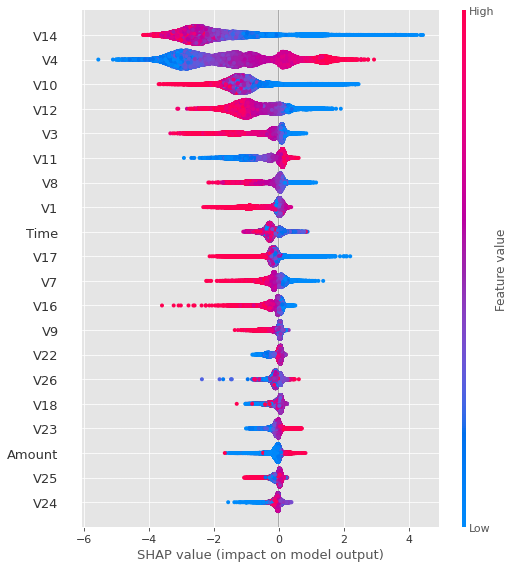

In [ ]:
shap.summary_plot(shap_values, X_test)

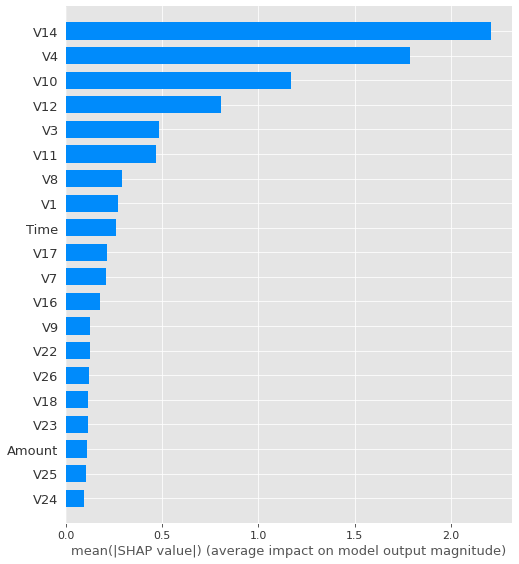

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type='bar')